# Outlier Detection Using Unsupervised Machine Learning

## Introduction to Anomaly Detection with PyOD

Welcome to this hands-on lab on **anomaly detection** using the **Python Outlier Detection (PyOD)** library. This notebook will guide you through various machine learning-based approaches to detect anomalies in time series data.

### What is Anomaly Detection?

**Anomaly detection** (also called outlier detection) is the process of identifying data points, events, or observations that deviate significantly from the majority of the data. Unlike statistical methods that rely on simple thresholds and distributions, machine learning approaches can:

- Handle **high-dimensional data** with multiple features
- Detect **complex patterns** that simple statistics might miss
- Learn **contextual relationships** between features
- Adapt to **non-linear patterns** in the data

### Types of Anomalies

1. **Point Anomalies**: Individual data points that are anomalous (e.g., an unusually high taxi ridership on a random Tuesday)
2. **Contextual Anomalies**: Data points that are anomalous in a specific context (e.g., low ridership on a holiday is normal, but low ridership on a regular workday is anomalous)
3. **Collective Anomalies**: A collection of related data points that are anomalous together (e.g., a sequence of unusual events)

### About PyOD

PyOD (Python Outlier Detection) is a comprehensive Python toolkit for detecting outliers in multivariate data. It provides:
- **30+ algorithms** from different families (statistical, proximity-based, clustering, neural networks)
- A **unified API** similar to scikit-learn
- **Scalable** implementations for large datasets
- Tools for **model evaluation and comparison**

In this lab, we'll explore algorithms from different families and learn when to use each approach.

# Technical Requirements

Before we begin, let's verify that we have all the necessary libraries installed. These libraries form the foundation of our anomaly detection toolkit.

In [1]:
import matplotlib 
import pandas as pd
import pyod 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
''')


Matplotlib -> 3.10.7
pandas -> 2.3.3   



In [2]:
from pyod import version
version.__version__

'2.0.5'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


plt.rcParams["figure.figsize"] = [12, 5]

## Dataset: NYC Taxi Ridership

We'll use NYC taxi ridership data, which contains the number of passengers over time. This is an excellent dataset for learning anomaly detection because:

- It has **clear seasonal patterns** (daily, weekly, yearly)
- It contains **known anomalies** (holidays, special events)
- It's a **real-world use case** (anomaly detection in transportation systems)

The dataset has observations every 30 minutes, showing how many taxi passengers were recorded during each time window.

In [4]:
file = Path("data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)
nyc_taxi.index.freq = '30min'

In [5]:
def plot_outliers(outliers, data, method='KNN', halignment='right', valignment='bottom', labels=False):
    """
    Plot time series data with highlighted outliers.
    
    Parameters
    ----------
    outliers : pandas.DataFrame or pandas.Series
        The DataFrame or Series containing the outlier data points.
    data : pandas.DataFrame or pandas.Series
        The complete time series data.
    method : str, default='KNN'
        The outlier detection method used, displayed in the plot title.
    halignment : str, default='right'
        Horizontal alignment for the date labels ('left', 'center', or 'right').
    valignment : str, default='bottom'
        Vertical alignment for the date labels ('top', 'center', or 'bottom').
    labels : bool, default=False
        If True, displays date labels for each outlier point.
        
    Returns
    -------
    None
        The function shows the plot but does not return any value.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
        
    data.plot(ax=ax, alpha=0.6)
    
    # Plot outliers
    if labels:
        outliers.plot(ax=ax, style='rx', markersize=8, legend=False)
        
        # Add text labels for each outlier
        for idx, value in outliers['value'].items():
            ax.text(idx, value, f'{idx.date()}', 
                   horizontalalignment=halignment, 
                   verticalalignment=valignment)
    else:
        outliers.plot(ax=ax, style='rx', legend=False)
    
    ax.set_title(f'NYC Taxi - {method}')
    ax.set_xlabel('date')
    ax.set_ylabel('# of passengers')
    ax.legend(['nyc taxi', 'outliers'])
    
    plt.tight_layout()
    plt.show()


## Visualize the Data and Known Anomalies

Before applying any algorithms, let's visualize the data and identify some **known anomalies**. These known anomalies will serve as our ground truth to evaluate how well our algorithms perform.

**Known Anomaly Dates:**
- **November 1, 2014**: NYC Marathon
- **November 27, 2014**: Thanksgiving
- **December 25, 2014**: Christmas
- **January 1, 2015**: New Year's Day
- **January 27, 2015**: Major snowstorm (Blizzard)

These dates should show unusual taxi ridership patterns compared to regular days.

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [7]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

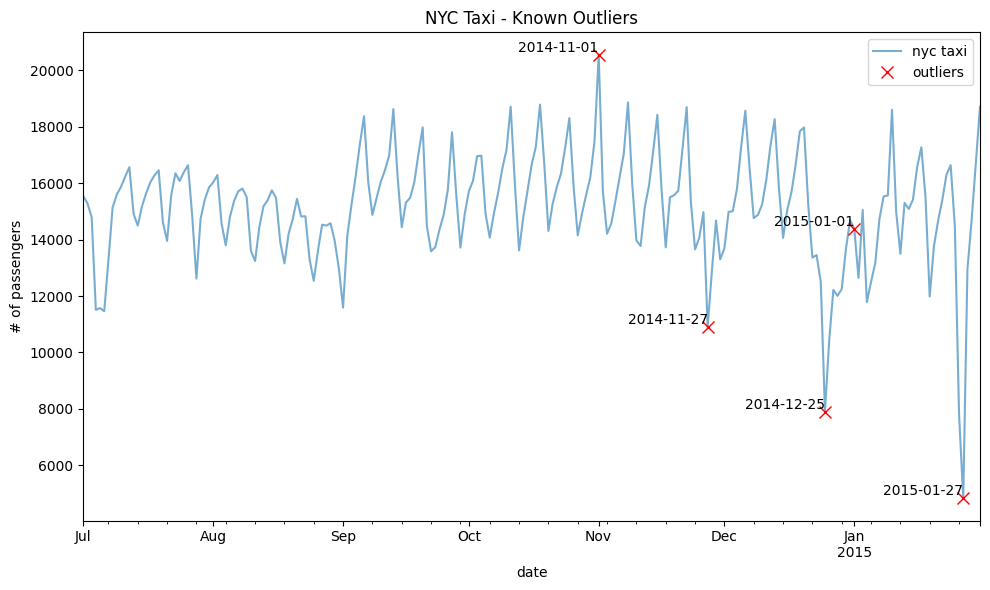

In [8]:
plot_outliers(known_outliers, tx, 'Known Outliers', labels=True)

In [9]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df

In [12]:
!uv pip install holidays

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Resolved 3 packages in 603ms                                         
Installed 1 package in 26ms                                 
 + holidays==0.83


In [13]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result

In [14]:
create_sliding_windows(tx, 2)

,pos_0,pos_1
timestamp,,
2014-07-03,15540.979167,15284.166667
2014-07-04,15284.166667,14794.625000
2014-07-05,14794.625000,11511.770833
2014-07-06,11511.770833,11572.291667
2014-07-07,11572.291667,11464.270833
...,...,...
2015-01-27,14463.791667,7818.979167
2015-01-28,7818.979167,4834.541667
2015-01-29,4834.541667,12947.562500


In [15]:
add_time_features(tx)

,value,dow_sin,dow_cos,month_sin,month_cos,year,time,is_holiday,is_weekend,is_month_start,is_month_end,is_commuting_day
timestamp,,,,,,,,,,,,
2014-07-01,15540.979167,0.781831,0.623490,-0.5,-0.866025,2014,1,0,0,1,0,1
2014-07-02,15284.166667,0.974928,-0.222521,-0.5,-0.866025,2014,2,0,0,0,0,1
2014-07-03,14794.625000,0.433884,-0.900969,-0.5,-0.866025,2014,3,0,0,0,0,1
2014-07-04,11511.770833,-0.433884,-0.900969,-0.5,-0.866025,2014,4,1,0,0,0,0
2014-07-05,11572.291667,-0.974928,-0.222521,-0.5,-0.866025,2014,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-27,4834.541667,0.781831,0.623490,0.5,0.866025,2015,211,0,0,0,0,1
2015-01-28,12947.562500,0.974928,-0.222521,0.5,0.866025,2015,212,0,0,0,0,1
2015-01-29,14686.145833,0.433884,-0.900969,0.5,0.866025,2015,213,0,0,0,0,1


# Detecting Outliers Using Distance-Based Algorithms (PyOD)

## What are Distance-Based Algorithms?

Distance-based algorithms identify anomalies by measuring how **far** data points are from their neighbors. The intuition is simple:

- **Normal points** are surrounded by many neighbors (they're in dense regions)
- **Anomalous points** are isolated and far from other points (they're in sparse regions)

These algorithms work well when anomalies are in low-density regions of the feature space.

---

## Algorithm 1: K-Nearest Neighbors (KNN)

### How KNN Works for Anomaly Detection

The **KNN algorithm** identifies outliers based on the distance to their k-nearest neighbors:

1. **For each data point**, find its k closest neighbors
2. **Calculate a distance metric** (e.g., mean, median, or largest distance to the k neighbors)
3. **Assign an anomaly score** based on this distance
4. **Points with large distances** to their neighbors are considered outliers

**Key Hyperparameters:**
- `n_neighbors` (k): How many neighbors to consider (default: 5)
- `method`: How to aggregate distances ('mean', 'median', 'largest')
- `contamination`: Expected proportion of outliers in the data (e.g., 0.03 = 3%)

**When to use KNN:**
- ✅ Simple to understand and interpret
- ✅ Works well when outliers are far from normal points
- ❌ Computationally expensive for large datasets
- ❌ Sensitive to the choice of k

---

## Algorithm 2: Local Outlier Factor (LOF)

### How LOF Works for Anomaly Detection

**LOF** is an improvement over KNN that considers **local density** rather than just distance:

1. **Calculate local density** for each point based on distances to its k neighbors
2. **Compare each point's density** to the density of its neighbors
3. **Compute LOF score**: Ratio of the point's density to its neighbors' average density
4. **Points in low-density regions** relative to their neighbors are outliers

**Key Differences from KNN:**
- LOF considers **relative density** (compares local densities)
- KNN uses **absolute distance** (compares distances directly)
- LOF handles **varying density regions** better than KNN

**Key Hyperparameters:**
- `n_neighbors`: Number of neighbors to use for density estimation (default: 20)
- `contamination`: Expected proportion of outliers

**When to use LOF:**
- ✅ Data has **clusters with different densities**
- ✅ Need to detect **local** anomalies (outliers within a cluster)
- ✅ More robust than KNN for complex data distributions
- ❌ Still computationally expensive for very large datasets

---

Let's apply both algorithms to detect point outliers in our taxi data!

In [16]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF

## Detecting Point Outliers

In this section, we apply KNN and LOF directly to the raw time series values. This approach detects **point anomalies** - individual observations that have unusual values compared to other observations, without considering temporal context or trends.

In [ ]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
print(knn)

In [ ]:
lof = LOF(contamination=0.03, 
          n_neighbors=20) 
print(lof)

In [ ]:
knn.fit(tx)
lof.fit(tx)

In [ ]:
knn_pred = pd.Series(knn.predict(tx), 
                      index=tx.index)

lof_pred = pd.Series(lof.predict(tx), 
                      index=tx.index)

In [ ]:
print('Number of KNN outliers = ', knn_pred.sum())
print('Number of LOF outliers = ', lof_pred.sum())

In [ ]:
# known outliers dates
print(tx.loc[nyc_dates])

In [ ]:
# extract the outlier values and dates from knn_pred
knn_outliers = knn_pred[knn_pred == 1]
knn_outliers = tx.loc[knn_outliers.index] 
print(knn_outliers)

In [ ]:
# extract the outlier values and dates from lof_pred
lof_outliers = lof_pred[lof_pred == 1]
lof_outliers = tx.loc[lof_outliers.index] 
print(lof_outliers)

In [ ]:
plot_outliers(knn_outliers, tx, 'KNN')

In [ ]:
plot_outliers(lof_outliers, tx, 'LOF')

In [ ]:
plot_outliers(known_outliers, tx, 'Known Outliers')

In [ ]:
plot_outliers(knn_outliers, 
              tx, 
              'KNN',
              labels=True)

## Detecting Outliers After Time Series Decomposition

### Why Decompose Time Series?

When detecting anomalies in time series, we often face a challenge: **seasonal patterns can mask true anomalies**. For example:
- Low taxi ridership on Christmas is **normal** (expected pattern)
- Low taxi ridership on a regular Tuesday is **anomalous** (unexpected)

**Time Series Decomposition** separates the data into components:
1. **Trend**: Long-term increase or decrease
2. **Seasonal**: Repeating patterns (daily, weekly, yearly)
3. **Residual**: What's left after removing trend and seasonality

### The Approach

By applying anomaly detection to the **residuals** instead of the raw data:
- We **remove expected patterns** (trend and seasonality)
- We focus on **genuine deviations** from normal behavior
- We detect **contextual anomalies** that would be hidden by seasonal effects

**STL (Seasonal and Trend decomposition using Loess)** is a robust method that works well even with missing data and outliers.

In [ ]:
from statsmodels.tsa.seasonal import STL

# For daily data with weekly seasonality
stl = STL(tx, seasonal=7)
result = stl.fit()
residuals = result.resid.dropna().to_frame()

residuals.plot(title='Residuals after STL decomposition');




In [ ]:
knn_decomp = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
lof_decomp = LOF(contamination=0.03, 
          n_neighbors=20) 

# Apply PyOD to residuals
knn_r = knn_decomp.fit(residuals)
lof_r = lof_decomp.fit(residuals)

knn_pred_r = pd.Series(knn_decomp.predict(residuals), 
                      index=residuals.index)

lof_pred_r = pd.Series(lof_decomp.predict(residuals), 
                      index=residuals.index)

In [ ]:
print('Number of KNN outliers after Decomposition = ', knn_pred_r.sum())
print('Number of LOF outliers  after Decomposition = ', lof_pred_r.sum())

In [ ]:
print(known_outliers)

In [ ]:
# extract the outlier values and dates from knn_pred_r
knn_outliers_r = knn_pred_r[knn_pred_r == 1]
knn_outliers_r = tx.loc[knn_outliers_r.index] 
print(knn_outliers_r)

In [ ]:
# extract the outlier values and dates from lof_pred_r
lof_outliers_r = lof_pred_r[lof_pred_r == 1]
lof_outliers_r = tx.loc[lof_outliers_r.index] 
print(lof_outliers_r)

In [ ]:
plot_outliers(knn_outliers_r, tx, 'KNN on residuals after decomposition - Original Taxi Plot', labels=True)

In [ ]:
res = residuals[knn_pred_r == 1]
res.columns = ['value']
plot_outliers(res, residuals, 'KNN on residuals after decomposition - Residual Plot', labels=True)

In [ ]:
plot_outliers(lof_outliers_r, tx, 'LOF on residuals after decomposition')

## Detecting Contextual Outliers with Sliding Windows

### What are Contextual Outliers?

A **contextual outlier** is a data point that's anomalous **in its specific context** but might be normal in a different context. For time series:
- A value might be normal by itself
- But **unusual given recent history**

Example: A taxi count of 10,000 might be normal, but if the previous 6 days all had 30,000, then 10,000 becomes anomalous.

### The Sliding Window Approach

Instead of looking at individual values, we create **windows of consecutive observations**:

1. **Create windows**: Each row contains a sequence of values (e.g., the last 7 days)
2. **Transform the problem**: Instead of 1 feature (value), we now have 7 features (pos_0, pos_1, ..., pos_6)
3. **Apply algorithms**: KNN and LOF now compare entire patterns, not just single values
4. **Detect anomalies**: Points with unusual patterns compared to their neighbors are flagged

**Benefits:**
- ✅ Captures **temporal patterns** and sequences
- ✅ Detects anomalies that manifest over **multiple time steps**
- ✅ Considers **recent history** when evaluating current values

**Window Size Selection:**
- Too small: Misses important patterns
- Too large: Computationally expensive, may include irrelevant information
- Common choices: 7 (weekly pattern), 30 (monthly pattern)

In [ ]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df


In [ ]:
tx_sw = create_sliding_windows(tx, window_size=7)
print(tx_sw.shape)

In [ ]:
knn_sw = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_sw = LOF(contamination=0.03, 
          n_neighbors=20)


knn_sw.fit(tx_sw)
lof_sw.fit(tx_sw)

knn_pred_sw = pd.Series(knn_sw.predict(tx_sw), 
                      index=tx_sw.index)

lof_pred_sw = pd.Series(lof_sw.predict(tx_sw), 
                      index=tx_sw.index)

print('Number of KNN outliers = ', knn_pred_sw.sum())
print('Number of LOF outliers = ', lof_pred_sw.sum())


In [ ]:
# known outliers dates
print(tx.loc[nyc_dates])

In [ ]:
knn_pred_sw

In [ ]:
# extract the outlier values and dates from knn_pred_sw
knn_outliers_sw = knn_pred_sw[knn_pred_sw == 1]
knn_outliers_sw = tx.loc[knn_outliers_sw.index] 
print(knn_outliers_sw)


In [ ]:
# extract the outlier values and dates from lof_pred_sw
lof_outliers_sw = lof_pred_sw[lof_pred_sw == 1]
lof_outliers_sw = tx.loc[lof_outliers_sw.index] 
print(lof_outliers_sw)


In [ ]:
plot_outliers(knn_outliers_sw, tx, 'KNN Sliding Window')

In [ ]:
plot_outliers(lof_outliers_sw, tx, 'LOF Sliding Window')

## Detecting Contextual Outliers with Feature Engineering

### The Power of Feature Engineering

While sliding windows capture recent history, **feature engineering** adds explicit **contextual information**:

- **Temporal features**: Day of week, month, year, time trends
- **Cyclical encoding**: Sine/cosine transformations for periodic patterns
- **Domain knowledge**: Holidays, weekends, special events

### Why Use Both Sliding Windows AND Features?

Combining both approaches gives us the best of both worlds:

1. **Sliding windows**: Capture raw sequential patterns
2. **Engineered features**: Add explicit context (e.g., "this is a Monday", "this is a holiday")

This creates a **rich feature space** where algorithms can learn that:
- Low ridership on a holiday is **normal**
- Low ridership on a regular Tuesday is **anomalous**

### Cyclical Encoding Explained

For periodic features like day of week (0-6) or month (1-12), we use **sine and cosine transformations**:

- **Why?** Prevents the algorithm from thinking day 6 (Saturday) is "far" from day 0 (Sunday)
- **How?** Maps the circular nature: sin(2π × day / 7) and cos(2π × day / 7)

This approach is more powerful than simply adding raw time features!

In [ ]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result 


In [ ]:
# combine with sliding windows for more context
windows = create_sliding_windows(tx, 7)
features = add_time_features(tx)
# Join the windows with the features at the corresponding dates
combined = pd.merge(
    windows, 
    features.drop(columns=['value']),  # Exclude the target value
    left_index=True, 
    right_index=True
)

print(combined.shape)

In [ ]:
knn_fe = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_fe = LOF(contamination=0.03, 
          n_neighbors=20)


knn_fe.fit(combined)
lof_fe.fit(combined)

knn_pred_fe = pd.Series(knn_fe.predict(combined), 
                      index=combined.index)

lof_pred_fe = pd.Series(lof_fe.predict(combined), 
                      index=combined.index)

# extract the outlier values and dates from knn_pred_fe
knn_outliers_fe = knn_pred_fe[knn_pred_fe == 1]
knn_outliers_fe = tx.loc[knn_outliers_fe.index] 
print(knn_outliers_fe)

In [ ]:
# extract the outlier values and dates from lof_pred_fe
lof_outliers_fe = lof_pred_fe[lof_pred_fe == 1]
lof_outliers_fe = tx.loc[lof_outliers_fe.index] 
print(lof_outliers_fe)

In [ ]:
plot_outliers(knn_outliers_fe, tx, 'KNN Sliding Window and Feature Engineering')

In [ ]:
plot_outliers(lof_outliers_fe, tx, 'LOF Sliding Window and Feature Engineering')

## Understanding PyOD's Internal Workflow

### From Anomaly Scores to Predictions

PyOD algorithms don't just output binary labels (0 = normal, 1 = anomaly). Instead, they follow a sophisticated workflow:

1. **Decision Scores**: Each point gets a continuous score indicating "how anomalous" it is
   - Higher score = more anomalous
   - Lower score = more normal

2. **Threshold Calculation**: Based on the `contamination` parameter
   - If contamination = 0.03, the threshold is set at the 97th percentile
   - Points above this threshold are labeled as anomalies

3. **Probabilities**: Scores can be converted to probabilities (0 to 1)
   - Two methods: 'linear' or 'unify'
   - Helps interpret "how confident" the model is

4. **Confidence Scores**: How certain the model is about its prediction
   - Low confidence = borderline case
   - High confidence = clear anomaly or clear normal point

### Why This Matters

Understanding the internals helps you:
- **Adjust sensitivity**: Modify thresholds instead of retraining
- **Rank anomalies**: Focus on the most severe cases first
- **Debug results**: Understand why certain points were flagged
- **Combine models**: Use scores from multiple algorithms

Let's explore these concepts with our KNN model!

In [ ]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

knn.fit(tx)

In [ ]:
knn_scores = knn.decision_scores_

In [ ]:
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df.quantile(0.97)

In [ ]:
knn_scores = knn.decision_function(tx)
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))
knn_scores_df.quantile(0.97)

In [ ]:
knn.threshold_

In [ ]:
print(knn_scores_df[knn_scores_df['score'] > knn.threshold_])

In [ ]:
n = int(len(tx)*0.03)
print(knn_scores_df.nlargest(n, 'score').sort_index())

In [ ]:
knn_scores_df.min()

In [ ]:
knn_scores_df.max()

In [ ]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

In [ ]:
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly'))

In [ ]:
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly').sort_index())

In [ ]:
knn_conf = knn.predict_confidence(tx)
knn_conf_df = (pd.DataFrame(knn_conf,
            index=tx.index,
            columns=['confidence']))
print(knn_conf_df.nsmallest(n, 'confidence').sort_index())

In [ ]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')
# load the model
knn = load('knn_outliers.joblib')

In [ ]:
knn

## Exploring KNN Hyperparameters

In this section, we explore how different **method** choices affect KNN's anomaly detection:

- **'mean'**: Uses the average distance to k neighbors
  - Balanced approach, reduces impact of single extreme neighbor
  
- **'median'**: Uses the median distance to k neighbors
  - More robust to outliers in the neighborhood
  
- **'largest'**: Uses the maximum distance to k neighbors
  - More sensitive, focuses on the farthest neighbor

**Try different methods** to see how they affect which points are flagged as anomalies!

In [ ]:
def knn_explore(df, method='mean', contamination=0.03, k=5):
    
    m = KNN(contamination=contamination,
              method=method,
              n_neighbors=k)
    m.fit(df)
    
    decision_score = pd.DataFrame(m.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, m.threshold_

In [ ]:
for method in ['mean', 'median', 'largest']:
    o, t = knn_explore(tx, method=method, contamination=0.05)
    print(f'Method= {method}, Threshold= {t}')
    print(o)

# Detecting Outliers Using Clustering-Based Algorithms (PyOD)

## What are Clustering-Based Algorithms?

Clustering-based algorithms use a different intuition than distance-based methods:

**Core Idea**: 
- First, **group similar data points** into clusters
- Then, identify points that **don't fit well** into any cluster
- Points far from cluster centers or in small/sparse clusters are anomalies

**Advantage over distance-based methods**:
- Can handle **complex data distributions** with multiple modes
- More efficient for **large datasets** (cluster first, then evaluate)
- Can detect anomalies as **points between clusters**

---

## Algorithm: Cluster-Based Local Outlier Factor (CBLOF)

### How CBLOF Works

CBLOF combines clustering with outlier scoring:

1. **Clustering Phase**: 
   - Apply clustering (e.g., K-means) to partition the data into `n_clusters` groups
   - Classify clusters as **large** (many points) or **small** (few points)

2. **Outlier Scoring**:
   - For points in **large clusters**: Score based on distance to cluster center
   - For points in **small clusters**: Score based on distance to nearest large cluster
   - Intuition: Small clusters are likely to contain outliers

3. **Final Score Calculation**:
   - Uses `alpha` and `beta` parameters to weight the contribution
   - `alpha`: Threshold to classify clusters as large vs. small (default: 0.9)
   - `beta`: Weight factor for small cluster penalty (default: 5)

### Key Hyperparameters

- **`n_clusters`**: Number of clusters to create
  - Too few: Might group anomalies with normal points
  - Too many: Normal points might form small clusters
  
- **`contamination`**: Expected proportion of outliers (e.g., 0.03 = 3%)

- **`alpha`**: Ratio to determine large vs. small clusters
  - Default 0.9 means: clusters with > 90% of average cluster size are "large"
  
- **`beta`**: Penalty multiplier for small clusters
  - Higher values = stronger penalty for points in small clusters

### When to Use CBLOF

- ✅ Data has **natural groupings** or clusters
- ✅ Need better **scalability** than pure distance-based methods
- ✅ Outliers are likely to be **isolated** or in sparse regions
- ❌ Need to choose the number of clusters (requires domain knowledge)
- ❌ Less effective if data doesn't have clear cluster structure

Let's see how CBLOF performs on our taxi data!

In [ ]:
from pyod.models.cblof import CBLOF

In [ ]:
cblof = CBLOF(n_clusters=8, 
              contamination=0.03,
              alpha=0.9,
              beta=5)
cblof

In [ ]:
cblof.fit(tx)
cblof_pred = pd.Series(cblof.predict(tx), 
                      index=tx.index)
print('Number of CBLOF outliers = ', cblof_pred.sum())

In [ ]:
# extract the outlier values and dates from cblof_pred
cblof_outliers = cblof_pred[cblof_pred == 1]
cblof_outliers = tx.loc[cblof_outliers.index] 
print(cblof_outliers)


In [ ]:
print(known_outliers)

In [ ]:
plot_outliers(cblof_outliers, tx, 'CBLOF')

In [ ]:
from pyod.utils import evaluate_print
# Create binary ground truth labels (1 for known outliers, 0 for normal points)
y = tx.index.isin(known_outliers.index).astype(int)
evaluate_print('CBLOF', y, cblof.decision_scores_)

# Detecting Outliers Using Probabilistic and Statistical Algorithms

## What are Probabilistic Algorithms?

Unlike distance or clustering methods, probabilistic algorithms model the **probability distribution** of the data:

**Core Idea**:
- Learn the **joint probability distribution** of all features
- Calculate how **probable** each data point is under this distribution
- Points with **low probability** are considered anomalies

**Advantages**:
- ✅ Theoretically grounded in **statistics and probability theory**
- ✅ Can handle **dependencies between features** 
- ✅ Often **parameter-free** or require minimal tuning
- ✅ Fast prediction after training

---

## Algorithm 1: COPOD (Copula-Based Outlier Detection)

### How COPOD Works

COPOD uses **copula theory** from statistics to model dependencies:

1. **Marginal Distributions**: 
   - Model each feature's distribution independently
   - Estimate the **empirical cumulative distribution function (ECDF)** for each feature
   
2. **Tail Probabilities**:
   - For each feature, compute left-tail and right-tail probabilities
   - Left-tail: P(X ≤ x) - how unusual is this low value?
   - Right-tail: P(X ≥ x) - how unusual is this high value?
   
3. **Copula-Based Combination**:
   - Use **copula functions** to combine probabilities across features
   - Captures dependencies between features without assuming specific distributions
   
4. **Outlier Score**:
   - Compute final score based on combined tail probabilities
   - Lower probability = higher anomaly score

### Key Advantages of COPOD

- **Parameter-free**: No hyperparameters to tune (except contamination)
- **Fast**: Linear time complexity O(n)
- **Interpretable**: Based on probability theory
- **Distribution-free**: Doesn't assume Gaussian or any specific distribution

### When to Use COPOD

- ✅ Need a **simple, fast** algorithm with **no tuning**
- ✅ Data has **multiple features** with potential dependencies
- ✅ Want **probabilistic interpretation** of anomaly scores
- ✅ Working with **large datasets** (very efficient)
- ❌ Data is highly complex and non-linear (consider deep learning methods)

---

## Algorithm 2: ECOD (Empirical Cumulative Distribution Outlier Detection)

ECOD is a simpler, even faster variant:

### How ECOD Works

1. **Empirical CDFs**: Compute ECDF for each feature independently
2. **Tail Probabilities**: Calculate left and right tail probabilities
3. **Independence Assumption**: Combines probabilities assuming feature independence
4. **Outlier Score**: Points in the tails of multiple features score highest

### COPOD vs. ECOD

| Feature | COPOD | ECOD |
|---------|-------|------|
| **Speed** | Fast | Even faster |
| **Dependencies** | Models feature dependencies | Assumes independence |
| **Accuracy** | Higher for correlated features | Good for independent features |
| **Complexity** | Uses copula theory | Simple tail probability |

Let's apply both algorithms to see how they perform!

In [ ]:
from pyod.models.copod import COPOD

In [ ]:
copod = COPOD(contamination=0.03)
copod.fit(tx)

In [ ]:
copod_pred = pd.Series(copod.predict(tx), 
                      index=tx.index)

In [ ]:
print('Number of COPOD outliers = ', copod_pred.sum())

In [ ]:
# extract the outlier values and dates from copod_pred
copod_outliers = copod_pred[copod_pred == 1]
copod_outliers = tx.loc[copod_outliers.index]
print(copod_outliers)

In [ ]:
known_outliers

In [ ]:
plot_outliers(copod_outliers, tx, 'COPOD')

In [ ]:
plot_outliers(known_outliers, tx, 'Known')

## Additional Probabilistic Methods: ECOD

In this section, we explore **ECOD** as another probabilistic approach. Compare its results with COPOD to see how the independence assumption affects anomaly detection!

In [ ]:
from pyod.models.ecod import ECOD

# Initialize and fit the ECOD model
ecod = ECOD(contamination=0.03)
ecod.fit(tx)

# Predict outliers
ecod_pred = pd.Series(ecod.predict(tx), 
                     index=tx.index)
print('Number of ECOD outliers = ', ecod_pred.sum())

# extract the outlier values and dates from ecod_pred
ecod_outliers = ecod_pred[ecod_pred == 1]
ecod_outliers = tx.loc[ecod_outliers.index]
print(ecod_outliers)

In [ ]:
plot_outliers(ecod_outliers, tx, 'ECOD')

# Detecting Outliers Using Kernel-Based Algorithms (PyOD)

## What are Kernel-Based Methods?

Kernel-based algorithms use **kernel functions** to transform data into higher-dimensional spaces where separation between normal and anomalous points becomes easier.

**Core Concept**:
- Data that's **not linearly separable** in the original space...
- ...might be **separable in a transformed (kernel) space**
- Use the **"kernel trick"** to work in high dimensions without explicitly computing the transformation

---

## Algorithm: One-Class SVM (OCSVM)

### How One-Class SVM Works

Unlike traditional SVM (which learns a boundary between two classes), **One-Class SVM** learns a boundary around **one class** (normal data):

1. **Map to Feature Space**:
   - Use a kernel function (RBF, linear, polynomial, sigmoid) to implicitly transform data
   - In this new space, find a **hyperplane** that separates normal data from the origin

2. **Learn the Decision Boundary**:
   - Fit a hyperplane that **encloses most normal points**
   - Points are allowed to fall outside based on the `nu` parameter
   - The hyperplane maximizes margin while allowing some flexibility

3. **Classify New Points**:
   - Points **inside the boundary** → normal
   - Points **outside the boundary** → anomalies

### Key Hyperparameters

1. **`kernel`**: The kernel function to use
   - **'rbf' (Radial Basis Function)**: Most popular, handles non-linear patterns
     - Creates smooth, circular decision boundaries
   - **'linear'**: Fastest, for linearly separable data
   - **'poly'**: Polynomial boundaries, can overfit
   - **'sigmoid'**: Neural network-like transformation

2. **`gamma`**: Kernel coefficient (for 'rbf', 'poly', 'sigmoid')
   - **'auto'**: Uses 1 / n_features
   - **High gamma**: Model focuses on nearby points (complex, can overfit)
   - **Low gamma**: Model considers distant points (simpler, smoother boundary)

3. **`nu`**: Upper bound on fraction of outliers and lower bound on fraction of support vectors
   - Similar to contamination, but interpreted differently
   - Range: (0, 1), typically 0.5
   - Higher nu → more flexible boundary, more points classified as outliers

### The Importance of Scaling

⚠️ **Critical**: OCSVM is **sensitive to feature scales**!

- Features with large ranges dominate the distance calculations
- **Always standardize/normalize** features before applying OCSVM
- Use `StandardScaler` or PyOD's `standardizer` utility

### When to Use OCSVM

- ✅ Data has **complex, non-linear patterns**
- ✅ Need a **robust** decision boundary
- ✅ Have **only normal data** for training (one-class problem)
- ✅ Can afford to **scale your features** properly
- ❌ Have very large datasets (can be slow)
- ❌ Need easy interpretability (kernel methods are "black box")

### Kernel Selection Guide

- **Start with 'rbf'**: Works well in most cases
- **Try 'linear'**: If data seems linearly separable or for baseline
- **Use 'poly'**: If you suspect polynomial relationships
- **Avoid 'sigmoid'**: Unless you have specific reasons

Let's see how OCSVM performs with different kernels!

In [ ]:
from pyod.models.ocsvm import OCSVM

In [ ]:
ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)
ocsvm.fit(tx)

In [ ]:
ocsvm_pred = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

In [ ]:
print('Number of OCSVM outliers = ', ocsvm_pred.sum())

In [ ]:
# extract the outlier values and dates from ocsvm_pred
ocsvm_outliers = ocsvm_pred[ocsvm_pred == 1]
ocsvm_outliers = tx.loc[ocsvm_outliers.index] 
print(ocsvm_outliers)

In [ ]:
print(known_outliers)

In [ ]:
plot_outliers(known_outliers, tx, 'Known')

In [ ]:
plot_outliers(ocsvm_outliers, tx, 'OCSVM')

In [ ]:
from pyod.utils.utility import standardizer

ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)

scaled = standardizer(tx)
ocsvm.fit(scaled)
ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                      index=tx.index)

# extract the outlier values and dates from ocsvm_pred_sc
ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index] 
print(ocsvm_outliers_sc)

In [ ]:
plot_outliers(ocsvm_outliers_sc, tx, 'OCSVM after scaling')

## Exploring Different Kernels

Different kernels can capture different types of patterns. Let's compare how 'linear', 'poly', 'rbf', and 'sigmoid' kernels detect anomalies in our taxi data.

**Watch for**:
- Which kernel finds the most known anomalies?
- Which kernel produces the most stable results?
- How do the decision boundaries differ?

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, 
                  kernel=kernel)
    ocsvm.fit(scaled)
    ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                              index=tx.index, 
                              name=kernel)
    ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
    ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index]
    print(f"Outliers using {kernel} kerenl: \n{ocsvm_outliers_sc}")
    #plot_outliers(ocsvm_outliers_sc, tx, f"OCSVM using {kernel} kernel")

# Detecting Outliers Using Ensemble Methods (PyOD)

## What are Ensemble Methods?

**Ensemble methods** combine multiple models or decision strategies to improve overall performance:

**Core Principle**: "Wisdom of the crowd"
- Individual models might make mistakes
- But **combining multiple models** often produces better results
- Different models capture different aspects of anomalies

**Types of Ensembles**:
1. **Bagging**: Train multiple models on random subsets of data
2. **Boosting**: Train models sequentially, focusing on hard cases
3. **Feature bagging**: Train models on random subsets of features
4. **Model combination**: Combine different algorithm types

---

## Algorithm 1: Isolation Forest (IForest)

### How Isolation Forest Works

IForest uses a unique approach based on **isolation** rather than distance or density:

**Key Insight**: 
- **Anomalies are rare and different** → easier to isolate
- **Normal points are common and similar** → harder to isolate

### The Algorithm

1. **Build Isolation Trees** (`n_estimators` trees):
   - Randomly select a feature
   - Randomly select a split value between min and max
   - Split the data recursively
   - Stop when each point is isolated or tree reaches max depth

2. **Measure Path Length**:
   - For each point, count how many splits needed to isolate it
   - **Anomalies** → isolated quickly → **short paths**
   - **Normal points** → many splits needed → **long paths**

3. **Aggregate Across Trees**:
   - Average path length across all trees
   - Normalize to get anomaly score
   - Shorter average path = higher anomaly score

### Visual Intuition

Imagine randomly drawing lines to separate points:
- An outlier sitting far from others gets separated in 1-2 cuts ✂️
- A normal point in a dense cluster needs many cuts ✂️✂️✂️✂️✂️

### Key Hyperparameters

1. **`n_estimators`**: Number of isolation trees (default: 100)
   - More trees → more stable, but slower
   - Typical range: 50-200

2. **`contamination`**: Expected proportion of outliers

3. **`bootstrap`**: Whether to use sampling with replacement
   - `True`: Each tree trained on a bootstrapped sample (introduces more diversity)
   - `False`: Each tree sees all data (faster, but less diverse)

4. **`max_samples`**: Number of samples to draw for each tree
   - Default: 256 or size of dataset if smaller
   - Larger → more accurate but slower
   - Smaller → faster but less stable

### Why Isolation Forest is Popular

- ✅ **Fast**: Linear time complexity O(n)
- ✅ **Scalable**: Works well with large datasets
- ✅ **Few parameters**: Easy to use
- ✅ **No need for distance/density computation**: Different paradigm
- ✅ **Handles high-dimensional data** well
- ✅ **Interpretable**: Path length has intuitive meaning

### When to Use IForest

- ✅ **Large datasets** (very efficient)
- ✅ **High-dimensional data** (doesn't suffer from curse of dimensionality)
- ✅ Need **fast training and prediction**
- ✅ Want a **parameter-free** method (works well with defaults)
- ✅ Outliers are **globally anomalous** (not local anomalies)

---

## Algorithm 2: Deep Isolation Forest (DIF)

### What is DIF?

**DIF** is an advanced variant that combines:
- Isolation Forest's isolation principle
- Deep learning's representation learning

### How DIF Improves on IForest

1. **Feature Representation**:
   - Uses neural networks to learn better feature representations
   - Can capture **non-linear relationships** automatically

2. **Ensemble of Representations**:
   - Each tree uses a different learned representation
   - More diverse ensemble → better performance

### When to Use DIF

- ✅ Data has **complex, non-linear patterns**
- ✅ Have **sufficient training data** for deep learning
- ✅ Standard IForest doesn't perform well
- ❌ Need fast training (DIF is slower than IForest)
- ❌ Need interpretability (neural networks are less interpretable)

Let's apply both IForest and DIF to our taxi data!

In [ ]:
from pyod.models.iforest import IForest

In [ ]:
iforest = IForest(contamination=0.03,
                 n_estimators=100,
                 bootstrap=False,
                 random_state=45)
iforest.fit(tx)

In [ ]:
iforest_pred = pd.Series(iforest.predict(tx), 
                      index=tx.index)

In [ ]:
print('Number of IForest outliers = ', iforest_pred.sum())

In [ ]:
# extract the outlier values and dates from iforest_pred
iforest_outliers = iforest_pred[iforest_pred == 1]
iforest_outliers = tx.loc[iforest_outliers.index] 
print(iforest_outliers)

In [ ]:
plot_outliers(iforest_outliers, tx, 'IForest')

## Advanced Ensemble: Deep Isolation Forest (DIF)

Now let's explore DIF, which combines isolation with deep learning for potentially better anomaly detection on complex patterns.

In [ ]:
import pandas as pd
from pyod.models.dif import DIF
import warnings
warnings.filterwarnings('ignore')

# Initialize and fit the DIF model 
dif = DIF(contamination=0.03, n_estimators=100)
dif.fit(tx)

# Get outliers
dif_scores = dif.decision_scores_
dif_threshold = np.quantile(dif_scores, 0.97)  # Adjust percentile as needed
dif_outliers = tx[dif_scores > dif_threshold]
print(dif_outliers)

In [ ]:
plot_outliers(dif_outliers, tx, 'DIF')

# Detecting Outliers Using Deep Learning (PyOD)

## What are Deep Learning-Based Methods?

Deep learning brings **neural networks** to anomaly detection, offering powerful capabilities:

**Core Idea**:
- Use neural networks to **learn compressed representations** of normal data
- Points that **reconstruct poorly** from these representations are anomalies
- The network learns what "normal" looks like automatically

**Advantages**:
- ✅ **Automatic feature learning**: No manual feature engineering needed
- ✅ **Handle complex patterns**: Can model highly non-linear relationships
- ✅ **Scalable**: Works with high-dimensional data
- ✅ **Flexible**: Can incorporate various architectures

**Challenges**:
- ❌ **Computationally expensive**: Requires more time and resources
- ❌ **Hyperparameter tuning**: Learning rate, epochs, batch size, architecture
- ❌ **Less interpretable**: "Black box" compared to simpler methods
- ❌ **May overfit**: Especially with small datasets

---

## Algorithm 1: AutoEncoder

### What is an AutoEncoder?

An **AutoEncoder** is a neural network trained to **reconstruct its input**:

```
Input → Encoder → Compressed Representation (Bottleneck) → Decoder → Reconstructed Output
```

### How AutoEncoders Detect Anomalies

1. **Training Phase** (on normal data):
   - **Encoder**: Compresses input to a low-dimensional representation (bottleneck)
   - **Decoder**: Reconstructs input from the compressed representation
   - **Objective**: Minimize reconstruction error for normal points
   - The network learns to **encode patterns of normal data**

2. **Detection Phase**:
   - Pass new data through the trained AutoEncoder
   - Calculate **reconstruction error** = |input - reconstructed output|
   - **Normal points**: Small reconstruction error (network learned their patterns)
   - **Anomalous points**: Large reconstruction error (network never learned these patterns)

### Architecture Components

```
Input Layer (n features)
    ↓
Hidden Layer 1 (decreasing size)
    ↓
Hidden Layer 2 (even smaller)
    ↓
Bottleneck (smallest - the compressed representation)
    ↓
Hidden Layer 3 (increasing size)
    ↓
Hidden Layer 4 (same size as input)
    ↓
Output Layer (n features - reconstruction)
```

### Key Hyperparameters

1. **`lr` (learning rate)**: How fast the network learns
   - Too high: Network doesn't converge, unstable learning
   - Too low: Training is very slow
   - Typical range: 0.001 - 0.01

2. **`epoch_num`**: Number of complete passes through the data
   - Too few: Network doesn't learn enough (underfitting)
   - Too many: Network memorizes even anomalies (overfitting)
   - Start with 10-50, increase if needed
   - Use validation to find optimal value

3. **`batch_size`**: Number of samples per training update
   - Smaller: More updates, noisier gradient, can escape local minima
   - Larger: Faster training, more stable gradient, more memory
   - Typical values: 16, 32, 64, 128

4. **Architecture** (hidden layers, neurons):
   - Deeper: Can learn more complex patterns
   - Bottleneck size: Should be much smaller than input (compression)

### Training Tips

**Underfitting Signs**:
- High reconstruction error even on normal data
- Solution: Train longer (more epochs), add capacity (more layers/neurons)

**Overfitting Signs**:
- Training error very low, but poor anomaly detection
- Network reconstructs anomalies well (memorized them)
- Solution: Early stopping, regularization, more training data

### When to Use AutoEncoders

- ✅ **High-dimensional data** (e.g., images, text, many features)
- ✅ Data has **complex, non-linear patterns**
- ✅ Have **sufficient normal training data**
- ✅ Can afford **longer training time**
- ❌ Small datasets (simpler methods might work better)
- ❌ Need fast, real-time detection without GPU
- ❌ Need interpretable results

---

## Algorithm 2: Variational AutoEncoder (VAE)

### What is a VAE?

**VAE** is a probabilistic variant of AutoEncoder:

**Key Differences**:
1. **Probabilistic encoding**: Instead of a single compressed representation, VAE learns a **distribution** (mean and variance)
2. **Regularization**: Forces the learned distribution to be close to a standard normal distribution
3. **Generative**: Can generate new samples (not just reconstruct)

### How VAE Detects Anomalies

1. **Encoder**: Maps input to a probability distribution (μ, σ)
2. **Sampling**: Sample from this distribution (with reparameterization trick)
3. **Decoder**: Reconstructs from the sample
4. **Anomaly Score**: Combination of:
   - Reconstruction error (like AutoEncoder)
   - KL divergence (how far the learned distribution is from standard normal)

### VAE vs. AutoEncoder

| Feature | AutoEncoder | VAE |
|---------|-------------|-----|
| **Output** | Deterministic | Probabilistic |
| **Regularization** | Optional | Built-in (KL divergence) |
| **Overfitting** | More prone | More robust |
| **Anomaly Score** | Reconstruction error | Reconstruction + KL |
| **Complexity** | Simpler | More complex |
| **Performance** | Good | Often better, more robust |

### When to Use VAE over AutoEncoder

- ✅ Want more **robust** anomaly detection
- ✅ Need **generative capabilities**
- ✅ Have **diverse** anomaly types
- ✅ Want built-in **regularization**

Let's apply both AutoEncoder and VAE to see how deep learning performs!

In [ ]:
# !pip install torch
# !pip install tqdm

In [ ]:
from pyod.models.auto_encoder import AutoEncoder

In [ ]:
# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=10,
                           batch_size=32)
auto_encoder.fit(tx)

In [ ]:
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)

In [ ]:
print('Number of AutoEncoder outliers = ', ae_predicted.sum())

In [ ]:
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

In [ ]:
ae_scores = pd.Series(auto_encoder.decision_scores_, 
                      index=tx.index)

threshold = auto_encoder.threshold_
# or you can do it using quantile 
threshold = ae_scores.quantile(0.97)

In [ ]:
ae_outliers =tx[ae_scores > ae_scores.quantile(0.97)]
print(ae_outliers)

In [ ]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

In [ ]:
%%time
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
auto_encoder.fit(tx)
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

In [ ]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

## Advanced Deep Learning: Variational AutoEncoder (VAE)

Now let's explore **VAE**, a more sophisticated variant that often provides more robust anomaly detection through its probabilistic approach.

**Watch for**:
- Does VAE find different anomalies than the standard AutoEncoder?
- How does the probabilistic approach affect the results?
- Which deep learning method works better for our taxi data?

In [ ]:
from pyod.models.vae import VAE

# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
vae = VAE(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
vae.fit(tx)

vae_predicted = pd.Series(vae.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
vae_outliers = vae_predicted[vae_predicted == 1]
vae_outliers = tx.loc[vae_outliers.index] 
print(vae_outliers)

# Summary and Key Takeaways

## Algorithms We Explored

Throughout this lab, we explored **8+ different anomaly detection algorithms** across multiple families:

### 1. **Distance-Based Algorithms**
- **KNN (K-Nearest Neighbors)**: Uses average/median/max distance to k neighbors
  - Simple, interpretable, but computationally expensive
  - Works well when outliers are far from normal points

- **LOF (Local Outlier Factor)**: Uses local density comparison
  - Better than KNN for data with varying density
  - Detects local anomalies within clusters

### 2. **Clustering-Based Algorithms**
- **CBLOF (Cluster-Based Local Outlier Factor)**: Clusters first, then scores
  - Efficient for large datasets
  - Works well when data has natural groupings
  - Points in small clusters or far from clusters are anomalies

### 3. **Probabilistic/Statistical Algorithms**
- **COPOD (Copula-Based Outlier Detection)**: Uses copula theory
  - Parameter-free (except contamination)
  - Fast, handles feature dependencies
  - Based on tail probabilities

- **ECOD (Empirical Cumulative Outlier Detection)**: Simpler than COPOD
  - Even faster, assumes feature independence
  - Good baseline method

### 4. **Kernel-Based Algorithms**
- **OCSVM (One-Class SVM)**: Learns decision boundary using kernels
  - Handles non-linear patterns through kernel trick
  - Requires feature scaling
  - Multiple kernel options (rbf, linear, poly, sigmoid)

### 5. **Ensemble Methods**
- **Isolation Forest**: Uses isolation trees to detect outliers
  - Very fast and scalable
  - Works well with high-dimensional data
  - Based on "ease of isolation" principle

- **DIF (Deep Isolation Forest)**: Combines isolation with deep learning
  - More sophisticated than IForest
  - Can learn better representations

### 6. **Deep Learning Methods**
- **AutoEncoder**: Neural network that learns to reconstruct normal data
  - Detects anomalies through reconstruction error
  - Good for complex, high-dimensional patterns
  - Requires tuning (learning rate, epochs, batch size)

- **VAE (Variational AutoEncoder)**: Probabilistic variant of AutoEncoder
  - More robust than standard AutoEncoder
  - Uses both reconstruction error and KL divergence
  - Better regularization through probabilistic approach

---

## Techniques for Better Anomaly Detection

### 1. **Time Series Decomposition**
- Separate trend, seasonality, and residuals
- Apply anomaly detection to residuals
- Removes seasonal patterns that could hide true anomalies

### 2. **Sliding Windows**
- Create sequences of consecutive observations
- Detect patterns in temporal context
- Good for contextual anomalies

### 3. **Feature Engineering**
- Add temporal features (day of week, month, year)
- Use cyclical encoding for periodic features
- Incorporate domain knowledge (holidays, weekends)
- Combine with sliding windows for rich representations

### 4. **Feature Scaling**
- Essential for distance-based and kernel methods
- Use StandardScaler or PyOD's standardizer
- Not needed for tree-based methods (IForest)

---

## Choosing the Right Algorithm

| Scenario | Recommended Algorithm |
|----------|----------------------|
| **Large dataset, need speed** | Isolation Forest, COPOD, ECOD |
| **Small dataset** | KNN, LOF, OCSVM |
| **High-dimensional data** | Isolation Forest, AutoEncoder, VAE |
| **Complex non-linear patterns** | OCSVM (RBF), AutoEncoder, VAE |
| **Varying density clusters** | LOF, CBLOF |
| **Need interpretability** | KNN, Isolation Forest |
| **Parameter-free method** | COPOD, ECOD |
| **Time series with seasonality** | Use decomposition + any algorithm |
| **Contextual anomalies** | Sliding windows + feature engineering |

---

## PyOD Workflow Best Practices

1. **Initialize** the model with hyperparameters
   ```python
   model = KNN(contamination=0.03, n_neighbors=5)
   ```

2. **Fit** the model on data
   ```python
   model.fit(X)
   ```

3. **Get predictions** (binary labels: 0=normal, 1=anomaly)
   ```python
   predictions = model.predict(X)
   ```

4. **Get decision scores** (continuous scores)
   ```python
   scores = model.decision_scores_
   # or
   scores = model.decision_function(X)
   ```

5. **Get probabilities** (if needed)
   ```python
   proba = model.predict_proba(X, method='linear')
   ```

6. **Save/Load model**
   ```python
   from joblib import dump, load
   dump(model, 'model.joblib')
   model = load('model.joblib')
   ```

---

## Key Parameters

- **`contamination`**: Expected proportion of outliers (e.g., 0.03 = 3%)
  - Sets the threshold for classification
  - Critical parameter for all algorithms
  - Should be based on domain knowledge

- **`n_neighbors` (KNN, LOF)**: Number of neighbors to consider
  - Small k: More sensitive to local variations
  - Large k: Smoother, more global view

- **`n_clusters` (CBLOF)**: Number of clusters
  - Domain-dependent
  - Try different values and evaluate

- **`kernel`, `gamma`, `nu` (OCSVM)**: Control decision boundary
  - Start with 'rbf' kernel and 'auto' gamma
  - Adjust based on results

- **`n_estimators` (IForest)**: Number of trees
  - More trees = more stable, but slower
  - 100 is usually sufficient

- **`lr`, `epoch_num`, `batch_size` (AutoEncoder, VAE)**: Training parameters
  - Require experimentation
  - Use validation to find optimal values

---

## Evaluation Strategies

1. **Use known anomalies** (if available) as ground truth
2. **Visual inspection**: Plot detected anomalies
3. **Multiple algorithms**: Compare results across different methods
4. **Domain expertise**: Verify if detected anomalies make sense
5. **PyOD's evaluation utilities**:
   ```python
   from pyod.utils import evaluate_print
   evaluate_print('ModelName', y_true, decision_scores)
   ```

---

## Final Thoughts

**No single algorithm is best for all cases!**

- Start with **simple, fast methods** (COPOD, IForest)
- Try **multiple algorithms** and compare
- Consider the **specific characteristics** of your data
- Combine **domain knowledge** with algorithmic results
- Use **feature engineering** to improve detection
- **Visualize results** to build intuition

**The best approach is often**:
1. Try several algorithms
2. Ensemble their results (e.g., voting, averaging scores)
3. Incorporate domain knowledge
4. Iterate based on feedback

